### Notebook 2 - 

When the virtual machine broken, I elected to finish the assignment requirment using a windows based machine.  It was not possible to extract the dataset from hadoop to continue to analysis so I elected to use the same dataset extacted using python.

The shape of the data is the same as the in extracted in Hadoop.

In [1]:
import pandas as pd 
import numpy as np
import pandas_datareader as web 
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#relax the display limits on columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')


In [2]:
# import the csv file filtered on weather

df = pd.read_csv('weather.csv')

In [3]:
# look at the of the dataframe

df.shape


(10532, 6)

In [4]:
# convert the full date column to a date column

df['date'] = pd.to_datetime(df['date'])
df['date_extract'] = df['date'].dt.date


In [5]:
# extract the time  from the date column

# Assuming your DataFrame is named 'df' and the date column is named 'date_column'
#df['date'] = pd.to_datetime(df['date'])
#df['time_extract'] = df['date'].dt.time

In [6]:
df.head()


,target,id,date,query,author,tweet,date_extract
0,0,1467841885,2009-04-06 22:27:56,NO_QUERY,MissPassion,@thecoolestout Ehhh don't. Weather's gonna tak...,2009-04-06
1,0,1467912333,2009-04-06 22:46:44,NO_QUERY,Meg_Andruschak,@Steve_Buscemi the weather in Canada is freezing,2009-04-06
2,0,1467931501,2009-04-06 22:52:13,NO_QUERY,soulonfire68,We've been good. I'm not liking the snow right...,2009-04-06
3,0,1467960481,2009-04-06 23:00:26,NO_QUERY,breedimetria,@JessDubb lmao. U may have to wait for another...,2009-04-06
4,0,1468023365,2009-04-06 23:18:38,NO_QUERY,addictedtotext,it's going to be nice again tomorrow and then ...,2009-04-06


### Data Processing

#### Reference
1. https://medium.com/towards-data-science/another-twitter-sentiment-analysis-bb5b01ebad90
2. https://wblillyman.medium.com/real-world-example-of-data-scraping-cleaning-with-python-and-beautifulsoup-74e42e7936fe
3. 

In [7]:
# drop unnecessary columns 

df.drop(['id','date','query','author'],axis=1,inplace=True)

In [8]:
from bs4 import BeautifulSoup
import re
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

In [9]:
# removing @ symbols
pat1 = r'@[A-Za-z0-9_]+'
# removing weblinks
pat2 = r'https?://[^ ]+'

combined_pat = r'|'.join((pat1, pat2))
# updated web site listing
www_pat = r'www.[^ ]+'

# negative words that should not be updated or removed
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}

neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')


In [10]:
# remove noise such as html links, stop words / punctuation / #hashtags etc

def tweet_cleaner(text):
    # remove any HTLM references
    soup = BeautifulSoup(text, 'lxml')
    # create a new var called souped
    souped = soup.get_text()
    # removing @
    stripped = re.sub(combined_pat, '', souped)
    try:
        # ensure all texted is in the utf-8 format
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)

    # convert all text to lowercase only
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    
    # remove any url links 
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    
    # removes any white space using tokenize to join together text and then 
    # removing any resulting white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
   
    return (" ".join(words)).strip()


In [11]:
# Apply the function to the 'tweet' column and create a new column 'Processed_tweets'

start_index = 0
end_index = 10532

clean_tweet_texts = []

for i in range(start_index, end_index):
    if (i + 1) % end_index == start_index:
        print("Tweets %d of %d have been processed" % (i + 1, end_index))

    clean_tweet_texts.append(tweet_cleaner(df['tweet'][i]))

Tweets 10532 of 10532 have been processed


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10532 entries, 0 to 10531
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   target        10532 non-null  int64 
 1   tweet         10532 non-null  object
 2   date_extract  10532 non-null  object
dtypes: int64(1), object(2)
memory usage: 247.0+ KB


In [13]:
df.head()

,target,tweet,date_extract
0,0,@thecoolestout Ehhh don't. Weather's gonna tak...,2009-04-06
1,0,@Steve_Buscemi the weather in Canada is freezing,2009-04-06
2,0,We've been good. I'm not liking the snow right...,2009-04-06
3,0,@JessDubb lmao. U may have to wait for another...,2009-04-06
4,0,it's going to be nice again tomorrow and then ...,2009-04-06


In [14]:
# add a new column for the length of the text in the tweet column

df['tweet_len'] = [len(t) for t in df.tweet]

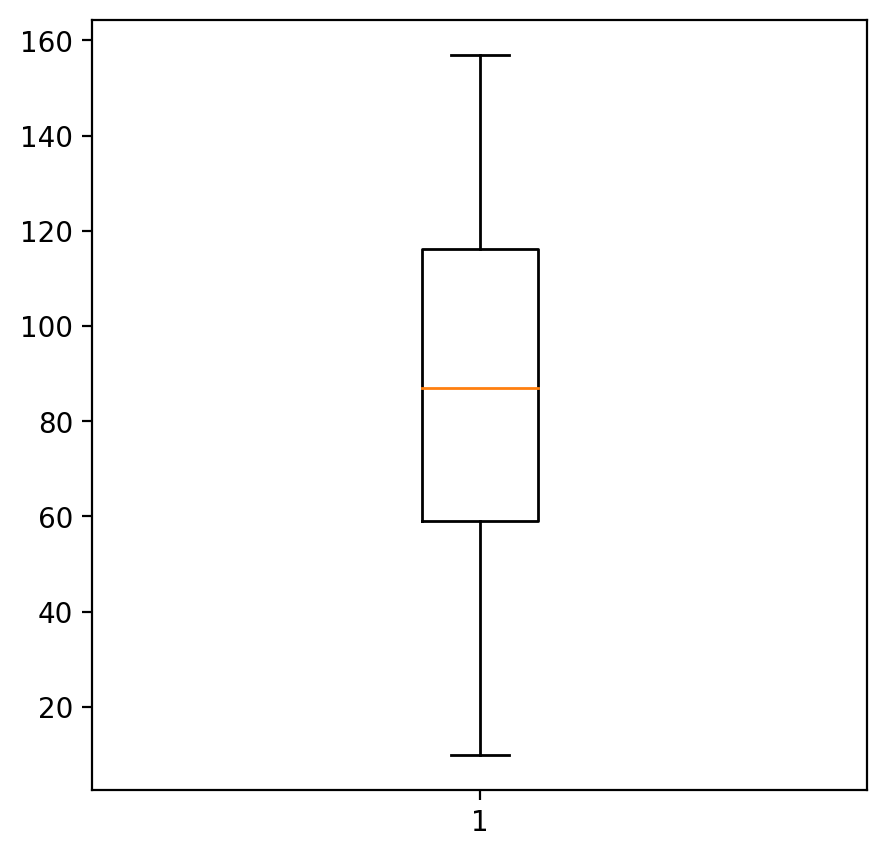

In [15]:
# look at the shape of the data

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.tweet_len)
plt.show()

In [16]:
# check for null values
null_values = df.isnull()

null_values_count = null_values.any().any()

print("Null value counts:", null_values_count)

Null value counts: False


In [17]:
# check for duplicate data
duplicates = df.duplicated()

# count the values
duplicate_count = duplicates.sum()

print("Duplicate count:", duplicate_count)

Duplicate count: 16


In [18]:
# drop the resulting duplicates

df.drop_duplicates(inplace=True)

In [19]:
# sort values by date order

df = df.sort_values(by='date_extract')

### Sentiment Analysis with TextBlob

TextBlob - common text processing operation, allowing NLP with an easy to use interface. uses sentiment analysis, parsing etc.


#### Reference

1. https://textblob.readthedocs.io/en/dev/quickstart.html
2. https://textblob.readthedocs.io/en/dev/quickstart.html?highlight=natural%20sentiment#sentiment-analysis
3. https://medium.com/towards-data-science/covid-19-vaccine-whats-the-public-sentiment-7149c9b42b99#29b2
4. https://www.analyticsvidhya.com/blog/2021/10/sentiment-analysis-with-textblob-and-vader/

In [20]:
from textblob import TextBlob

In [21]:
# Obtain sentiment scores generated by TextBlob

df['textblob_score'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [22]:
# review the new textblob score

# df.head()

In [23]:
# Set threshold to define neutral sentiment 
# a score greate than 0.05 is positive, 0 to 0.05 is Neutral and less than 1 is negative

neutral_thresh = 0.05

In [24]:
# Convert polarity score into sentiment categories

df['textblob_sentiment'] = df['textblob_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

In [25]:
df.head()

,target,tweet,date_extract,tweet_len,textblob_score,textblob_sentiment
0,0,@thecoolestout Ehhh don't. Weather's gonna tak...,2009-04-06,77,-0.70000,Negative
6294,4,Is quite pleased that the weather forecast for...,2009-04-06,118,0.40000,Positive
6292,4,"Getting a nice break, excited about classes an...",2009-04-06,119,0.46875,Positive
6291,4,"ready for nice weather, day drinking &amp; not...",2009-04-06,74,0.40000,Positive
6290,4,is home. Hmmm how lovely to be in 85 degree we...,2009-04-06,53,0.50000,Positive


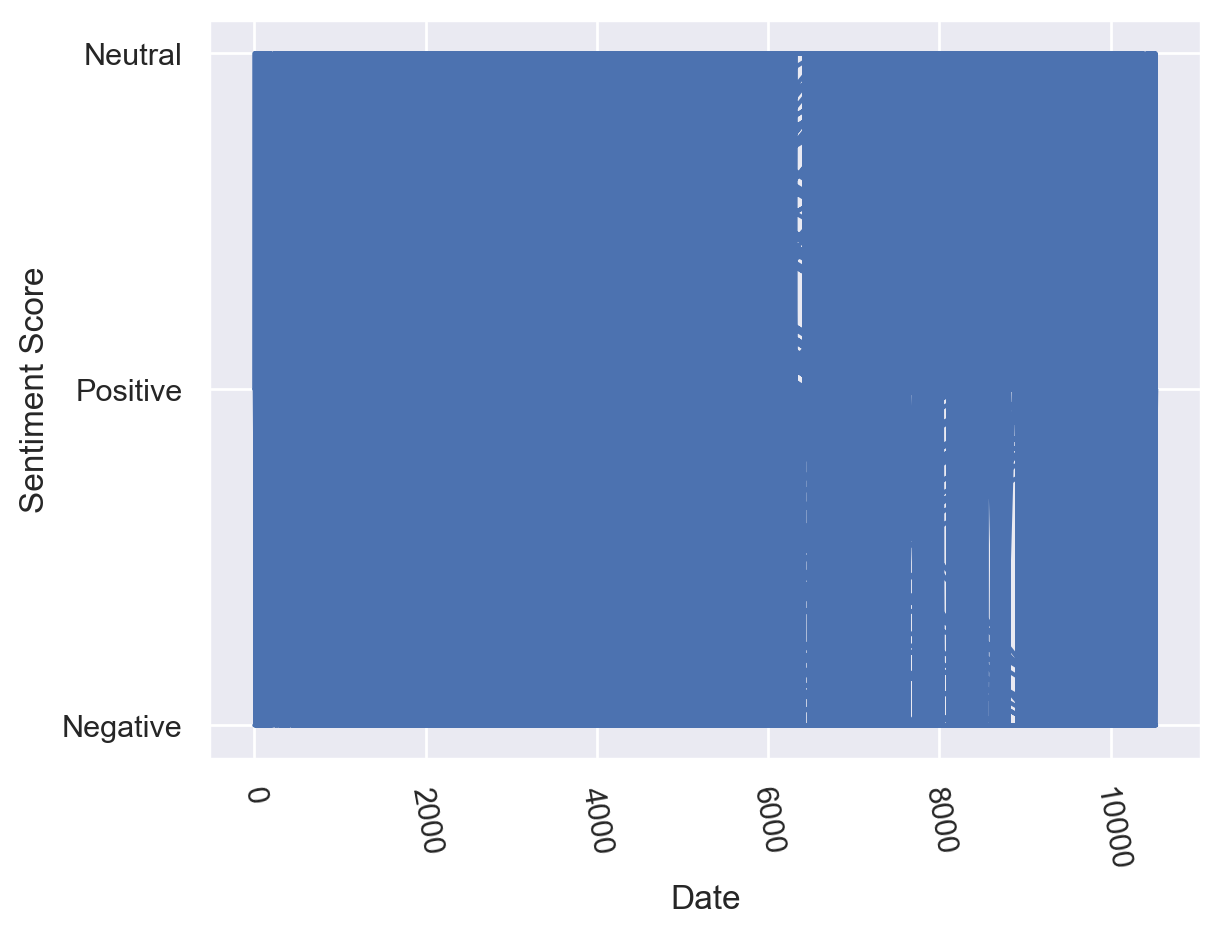

In [26]:
# Plot the sentiment scores

sns.set()

plt.ylabel('Sentiment Score')
plt.xlabel('Date')
plt.xticks(rotation=1000)
plt.plot(df.index, df['textblob_sentiment'])

plt.show()

#### Time Series Analysis 

##### References
1. https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
2. https://medium.com/towards-data-science/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
3. ARIMA - https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
4. ARIMA - https://medium.com/towards-data-science/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7


In [27]:
df.head()

,target,tweet,date_extract,tweet_len,textblob_score,textblob_sentiment
0,0,@thecoolestout Ehhh don't. Weather's gonna tak...,2009-04-06,77,-0.70000,Negative
6294,4,Is quite pleased that the weather forecast for...,2009-04-06,118,0.40000,Positive
6292,4,"Getting a nice break, excited about classes an...",2009-04-06,119,0.46875,Positive
6291,4,"ready for nice weather, day drinking &amp; not...",2009-04-06,74,0.40000,Positive
6290,4,is home. Hmmm how lovely to be in 85 degree we...,2009-04-06,53,0.50000,Positive


In [28]:
# Divide the DataFrame into one-week blocks

week_blocks = []
start_date = df['date_extract'].min()

while start_date <= df['date_extract'].max():
    end_date = start_date + pd.DateOffset(weeks=1)
    week_df = df[(df['date_extract'] >= start_date) & (df['date_extract'] < end_date)]
    week_blocks.append(week_df)
    start_date = end_date


In [29]:
#print(week_blocks)

In [30]:
# Divide the DataFrame into one-month blocks

month_blocks = []
start_date = df['date_extract'].min()
while start_date <= df['date_extract'].max():
    end_date = start_date + pd.DateOffset(months=1)
    month_df = df[(df['date_extract'] >= start_date) & (df['date_extract'] < end_date)]
    month_blocks.append(month_df)
    start_date = end_date

In [31]:
#print(month_blocks)

In [32]:
# Divide the DataFrame into three-month blocks

three_month_blocks = []
start_date = df['date_extract'].min()
while start_date <= df['date_extract'].max():
    end_date = start_date + pd.DateOffset(months=3)
    three_month_df = df[(df['date_extract'] >= start_date) & (df['date_extract'] < end_date)]
    three_month_blocks.append(three_month_df)
    start_date = end_date

In [33]:
#print(three_month_blocks)

In [34]:
# Divide the data set into test and train

# create a new df based on date which is less than 
train = df[df.date_extract <= pd.to_datetime("2009-04-30", format='%Y-%m-%d')]

# create a new df where the date is greater than or equal to 01 May
test = df[df.date_extract >= pd.to_datetime("2009-05-01", format='%Y-%m-%d')]

print("The shape of the train dataframe is ", train.shape)
print("The shape of the test dataframe is ", test.shape)

The shape of the train dataframe is  (844, 6)
The shape of the test dataframe is  (9672, 6)


In [35]:
# create test & train dataframe for weekly / Monthly and 3 month predictions
train = df[df.date_extract <= pd.to_datetime("2009-04-30", format='%Y-%m-%d')]

# create a new df where the date is greater than or equal to 01 May
test = df[df.date_extract >= pd.to_datetime("2009-05-01", format='%Y-%m-%d')]

In [36]:
# Function to fit ARIMA model and make predictions

def fit_arima(train_series, test_series):
    # Fit ARIMA model with (p, d, q) parameters
    model = ARIMA(train_series, order=(1, 1, 1))
    model_fit = model.fit()
    
    # Make predictions for the test set
    forecast = model_fit.forecast(steps=len(test_series))
    predictions = forecast
    
    return predictions

In [37]:
# Apply ARIMA on each block of week / month and 3 months to make predictions

week_predictions = [fit_arima(block['target'][:-1], block['target'][-1:]) for block in week_blocks]

month_predictions = [fit_arima(block['target'][:-1], block['target'][-1:]) for block in month_blocks]

three_month_predictions = [fit_arima(block['target'][:-1], block['target'][-1:]) for block in three_month_blocks]



In [38]:
# Apply ARIMA on the train set and make predictions for the test set
train_series = train['target']

test_series = test['target']

In [39]:
# predictions based on the full dataset
predictions = fit_arima(train_series, test_series)

In [40]:
# Print the predictions
#print("ARIMA Predictions on full dataset:", predictions)

##### Apply data to a weekly dataset

In [41]:
# predictions based on weekly data 
week_predictions = fit_arima(train_series, test_series)

In [42]:
# Apply ARIMA on the train set and make predictions for the test set
Weeky_train_series = train['target']

Weeky_test_series = test['target']

In [43]:
# Print the predictions
#print("ARIMA Predictions on full dataset:", week_predictions)

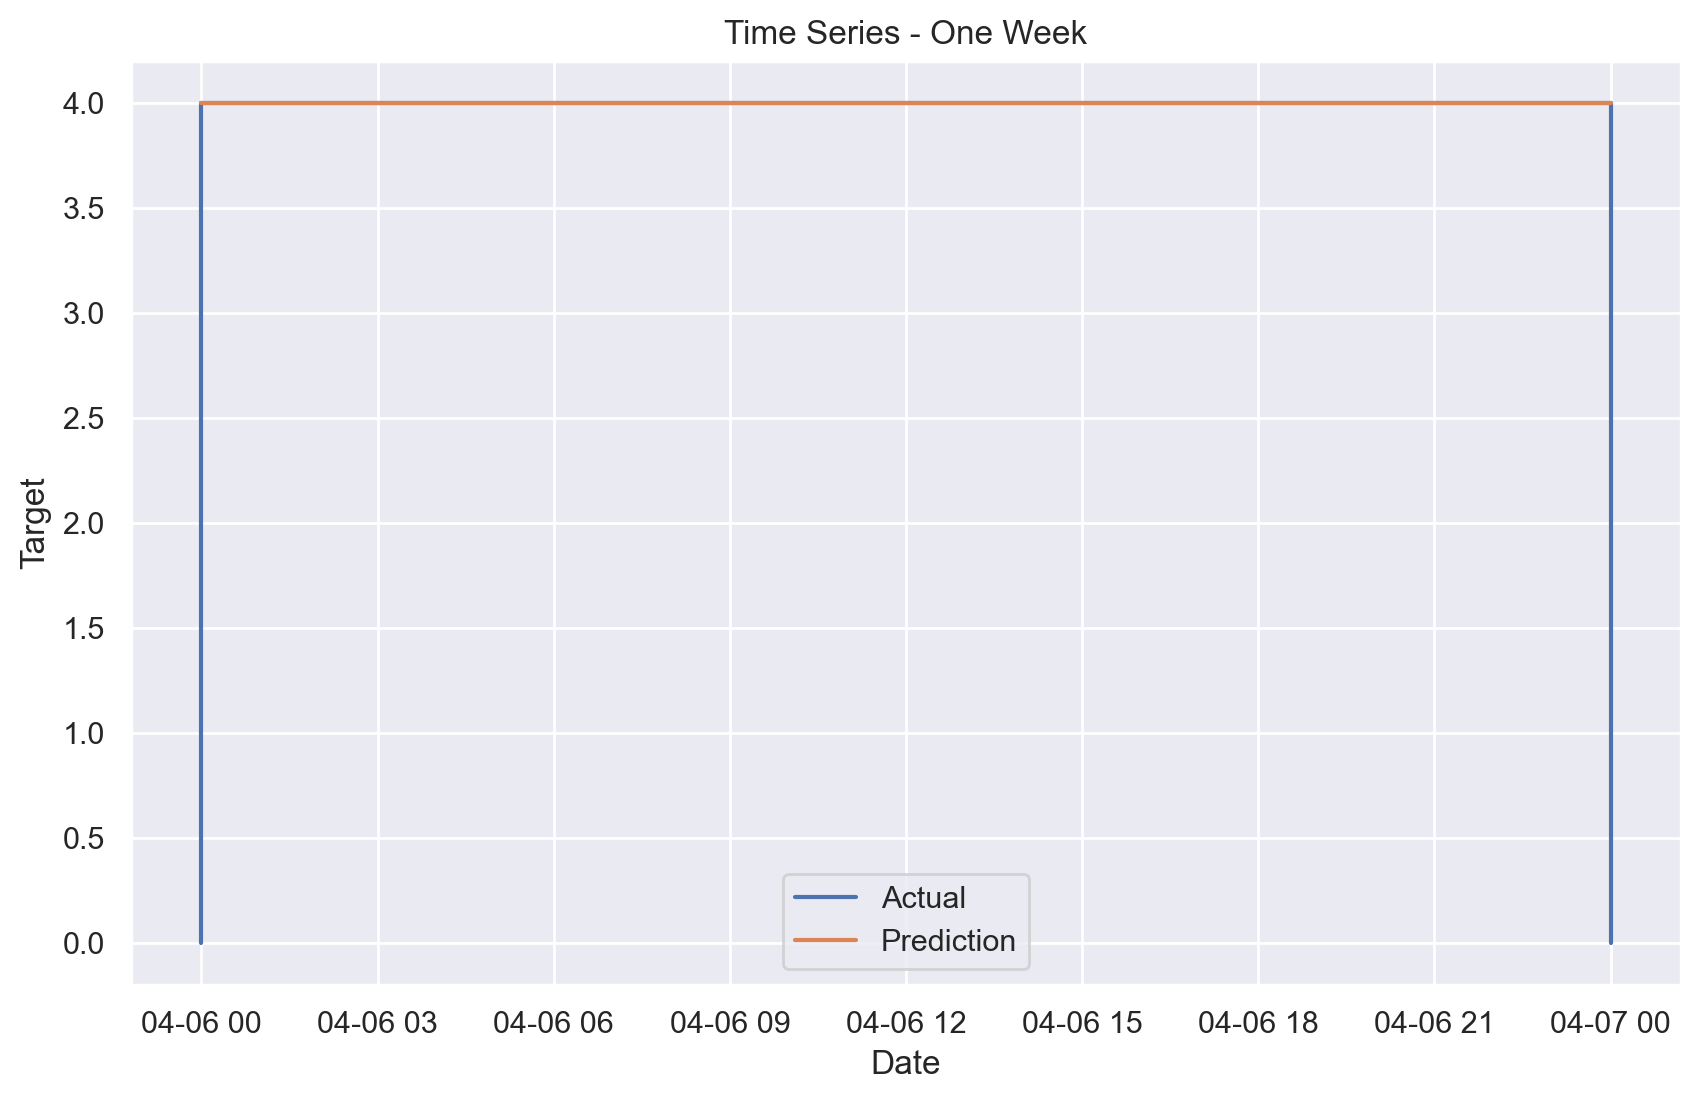

In [44]:
# Plot the time series and predictions for one week

plt.figure(figsize=(10, 6))
plt.plot(week_blocks[0]['date_extract'], week_blocks[0]['target'], label='Actual')
plt.plot(week_blocks[0]['date_extract'], week_predictions[:len(week_blocks[0])], label='Prediction')
plt.xlabel('Date')
plt.ylabel('Target')
plt.title('Time Series - One Week')
plt.legend()
plt.show()



#### Apply to a monthly dataset

In [45]:
# predictions based on one month of data 
month_predictions = fit_arima(train_series, test_series)

In [46]:
# Apply ARIMA on the train set and make predictions
month_train_series = train['target']

month_test_series = test['target']

In [47]:
# Print the predictions
#print("ARIMA Predictions on full dataset:", month_predictions)

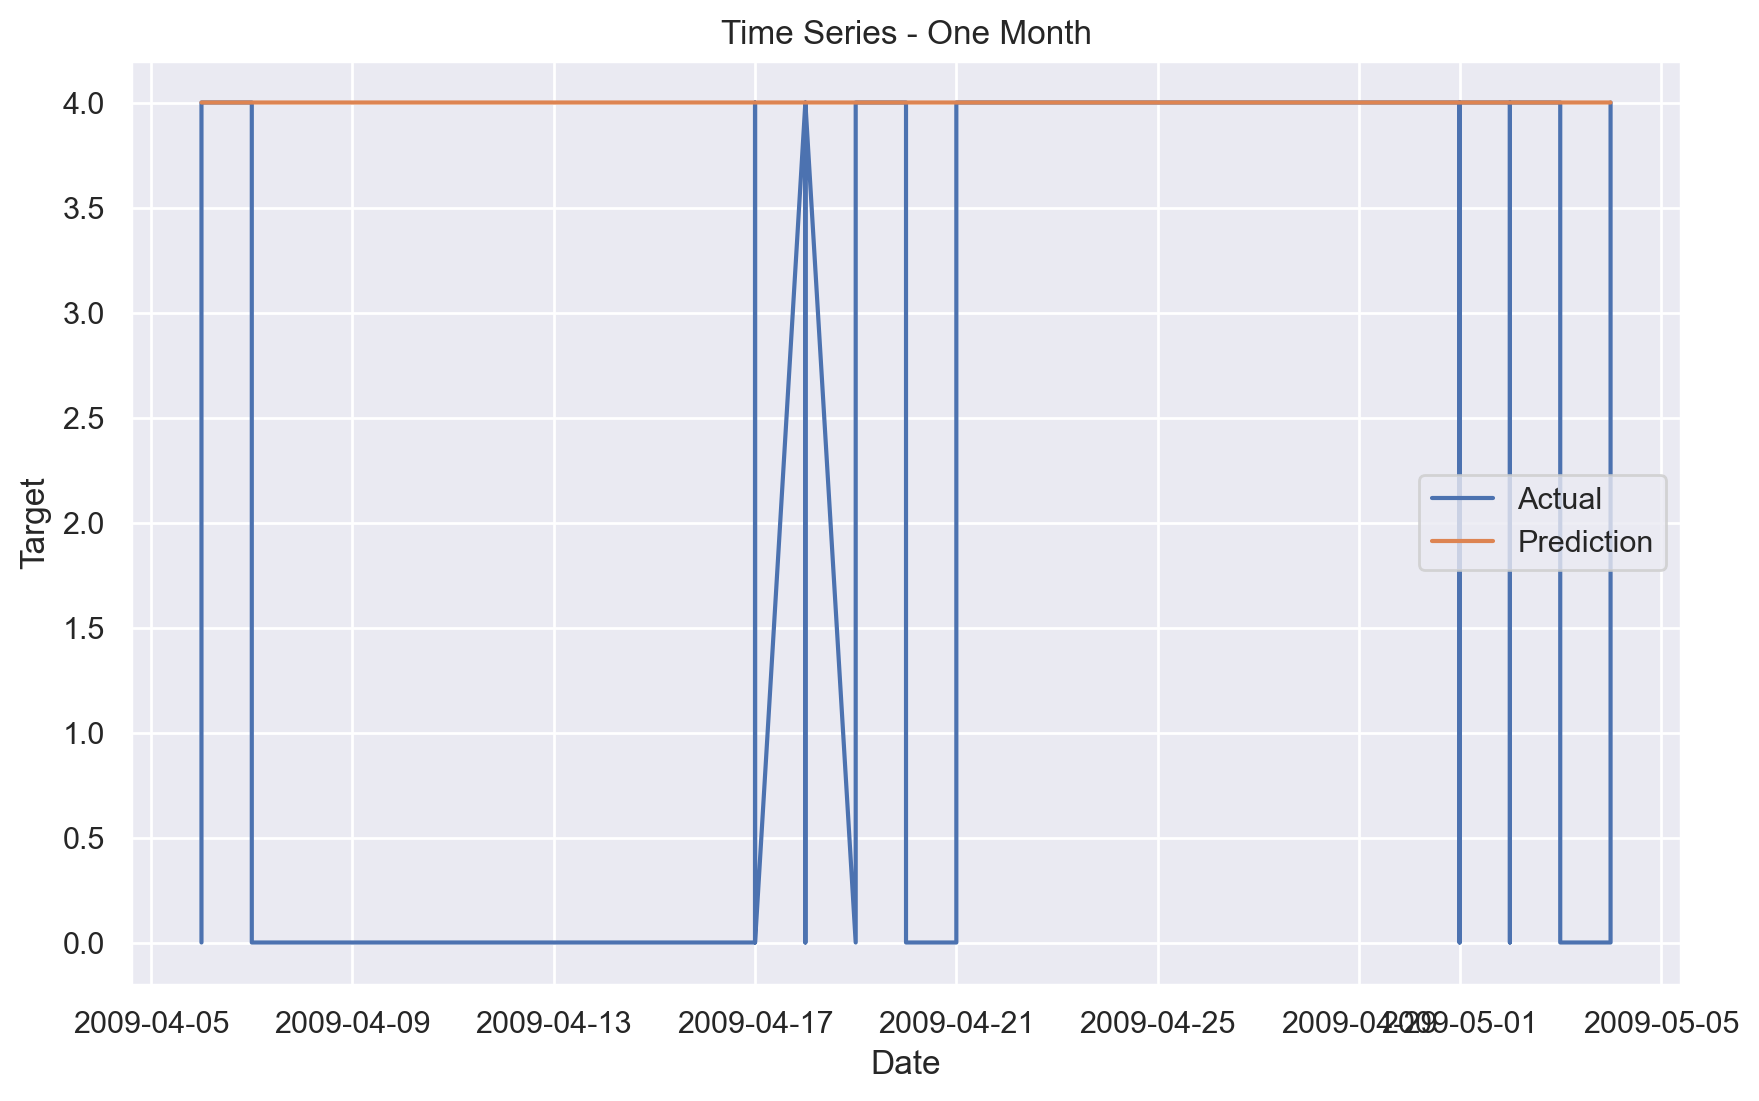

In [48]:
# Plot the time series and predictions for one week

plt.figure(figsize=(10, 6))
plt.plot(month_blocks[0]['date_extract'], month_blocks[0]['target'], label='Actual')
plt.plot(month_blocks[0]['date_extract'], month_predictions[:len(month_blocks[0])], label='Prediction')
plt.xlabel('Date')
plt.ylabel('Target')
plt.title('Time Series - One Month')
plt.legend()
plt.show()

#### Three Month Preditions

In [49]:
# predictions based on the three months of data
three_month_predictions = fit_arima(train_series, test_series)

In [50]:
# Apply ARIMA on the train set and make predictions for the test set
three_month_train_series = train['target']

three_month_test_series = test['target']

In [51]:
# Print the predictions
#print("ARIMA Predictions on full dataset:", three_month_predictions)

In [53]:
# Plot the time series and predictions for three months

#plt.figure(figsize=(10, 6))
#plt.plot(three_month_blocks[0]['date_extract'].reset_index(drop=True), three_month_blocks[0]['target'], label='Actual')
#plt.plot(three_month_blocks[0]['date_extract'].reset_index(drop=True), three_month_predictions[:len(three_month_blocks[0])], label='Prediction')
#plt.xlabel('Date')
#plt.ylabel('Target')
#plt.title('Time Series - Three Months')
#plt.legend()
#plt.show()

### Interactive Dashboard

#### References

1. Interactive Dashboards - https://medium.com/towards-data-science/dash-for-beginners-create-interactive-python-dashboards-338bfcb6ffa4
2. Dashboards using dash - https://realpython.com/python-dash/
3. Tkinter - https://medium.com/@amitprius/tkinter-python-in-built-graphical-user-interface-gui-3ed4750f7124
4. GUI Programming with Tkinter - https://realpython.com/python-gui-tkinter/
5. Flask Web applications - https://realpython.com/python-web-applications-with-flask-part-i/
6. Flask - getting started - https://www.pluralsight.com/courses/flask-getting-started?clickid=1k0XIT1dTxyNUncy6C24VzeBUkASGVT1HQ1J1E0&irgwc=1&mpid=1137078&aid=7010a000001xAKZAA2&utm_medium=digital_affiliate&utm_campaign=1137078&utm_source=impactradius
7. Python web apps with flask - https://www.codecademy.com/learn/paths/build-python-web-apps-flask?periods=year&plan_id=proGoldAnnualV2&utm_source=pepperjam&utm_medium=affiliate&utm_term=225746&clickId=4395300176&pj_creativeid=8-12462&pj_publisherid=225746

In [54]:
# interactive plot libaries

import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px


In [55]:
# initialize the Flask app

app = dash.Dash(__name__)


In [56]:
# Define the layout of the dashboard using HTML components and Dash components:

@app.callback(
    dash.dependencies.Output('graph', 'figure'),
    [dash.dependencies.Input('dropdown', 'value')]
)

# Function to update the graph based on the selected value
def update_graph(selected_value):
    
    # Example: Generate a plotly express figure based on the selected value
    fig = px.scatter(data_frame=data, x='x', y='y', color=selected_value)
    
    return fig


In [57]:
# cmds to run the dashboard

if __name__ == '__main__':
    app.run_server(debug=True)


Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: on


SystemExit: 1

SystemExit: 1